# Example that use the code implemented for FUCONE

In [14]:
# Authors: Sylvain Chevallier <sylvain.chevallier@uvsq.fr>,
#          Marie-Constance Corsi <marie.constance.corsi@gmail.com>
# License: BSD (3-clause)

import hashlib
import os.path as osp
import os
from time import time
import numpy as np

from mne import get_config, set_config, set_log_level, EpochsArray
from mne.connectivity import spectral_connectivity
from mne.connectivity import envelope_correlation

from scipy import stats as spstats

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.covariance import ledoit_wolf
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import get_scorer
from sklearn.linear_model import LogisticRegression

from mne.epochs import BaseEpochs

from pyriemann.classification import FgMDM
from pyriemann.estimation import Coherences
from pyriemann.tangentspace import TangentSpace

from moabb import set_log_level
from moabb.evaluations import WithinSessionEvaluation
import warnings
from moabb.datasets import (
    BNCI2015004,
    Cho2017
)
# actually, we could use also the eegbci dataset available in mne if you prefer...
from moabb.paradigms import MotorImagery, LeftRightImagery
from moabb.pipelines.csp import TRCSP
from moabb.evaluations.base import BaseEvaluation
from moabb.analysis.meta_analysis import (
    compute_dataset_statistics,
    find_significant_differences
)
from moabb.analysis.plotting import paired_plot, summary_plot

import seaborn as sns

# TODO: update the list depending on the steps we whoose to show...

In [2]:
def _compute_fc_subtrial(epoch, delta=1, ratio=0.5, method="coh", fmin=8, fmax=35):
    """Compute single trial functional connectivity (FC)

    Most of the FC estimators are already implemented in mne-python (and used here from
    mne.connectivity.spectral_connectivity and mne.connectivity.envelope_correlation).
    The epoch is split into subtrials.

    Parameters
    ----------
    epoch: MNE epoch
        Epoch to process
    delta: float
        length of the subtrial in seconds
    ratio: float, in [0, 1]
        ratio overlap of the sliding windows
    method: string
        FC method to be applied, currently implemented methods are: "coh", "plv",
        "imcoh", "pli", "pli2_unbiased", "wpli", "wpli2_debiased", "cov", "plm", "aec"
    fmin: real
        filtering frequency, lowpass, in Hz
    fmax: real
        filtering frequency, highpass, in Hz

    Returns
    -------
    connectivity: array, (nb channels x nb channels)
    

    references
    ----------
    .. [1] https://github.com/fieldtrip/fieldtrip/blob/master/connectivity/ft_connectivity_plm.m  # noqa
    .. [2] R. Oostenveld, P. Fries, E. Maris, J.-M. Schoffelen, and  R. Oostenveld,
    "FieldTrip: Open Source Software for Advanced Analysis of MEG, EEG, and Invasive
    Electrophysiological  Data" (2010): https://doi.org/10.1155/2011/156869
    """
    lvl = set_log_level("CRITICAL")
    L = epoch.times[-1] - epoch.times[0]
    sliding = ratio * delta
    # fmt: off
    spectral_met = ["coh", "plv", "imcoh", "pli", "pli2_unbiased",
                    "wpli", "wpli2_debiased", ]
    other_met = ["cov", "plm", "aec"]
    # fmt: on
    if not method in spectral_met + other_met:
        raise NotImplemented("this spectral connectivity method is not implemented")

    sfreq, nb_chan = epoch.info["sfreq"], epoch.info["nchan"]
    win = delta * sfreq
    nb_subtrials = int(L * (1 / (sliding + delta) + 1 / delta))
    nbsamples_subtrial = delta * sfreq

    # X, total nb trials over the session(s) x nb channels x nb samples
    X = np.squeeze(epoch.get_data())
    subtrials = np.empty((nb_subtrials, nb_chan, int(win)))

    for i in range(0, nb_subtrials):
        idx_start = int(sfreq * i * sliding)
        idx_stop = int(sfreq * i * sliding + nbsamples_subtrial)
        subtrials[i, :, :] = np.expand_dims(X[:, idx_start:idx_stop], axis=0)
    sub_epoch = EpochsArray(np.squeeze(subtrials), info=epoch.info)
    if method in spectral_met:
        r = spectral_connectivity(
            sub_epoch,
            method=method,
            mode="multitaper",
            sfreq=sfreq,
            fmin=fmin,
            fmax=fmax,
            faverage=True,
            tmin=0,
            mt_adaptive=False,
            n_jobs=1,
        )
        c = np.squeeze(r[0])
        c = c + c.T - np.diag(np.diag(c)) + np.identity(nb_chan)
    elif method == "aec":
        # filter in frequency band of interest
        sub_epoch.filter(
            fmin,
            fmax,
            n_jobs=1,
            l_trans_bandwidth=1,  # make sure filter params are the same
            h_trans_bandwidth=1,
        )  # in each band and skip "auto" option.
        # apply hilbert transform first
        h_sub_epoch = sub_epoch.apply_hilbert()
        c = envelope_correlation(h_sub_epoch, verbose=True)
        # by default, combine correlation estimates across epochs by peforming an average
        # output : nb_channels x nb_channels -> no need to rearrange the matrix
    elif method == "cov":
        c = ledoit_wolf(X.T)[0]  # oas ou fast_mcd

    return c


def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = np.linalg.cholesky(B)
        return True
    except np.linalg.LinAlgError:
        return False


def isPD2(B):
    """Returns true when input is positive-definite, via eigenvalues"""
    if np.any(np.linalg.eigvals(B) < 0.0):
        return False
    else:
        return True


def nearestPD(A, reg=1e-6):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): htttps://doi.org/10.1016/0024-3795(88)90223-6
    """
    B = (A + A.T) / 2
    _, s, V = np.linalg.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        # Regularize if already PD
        ei, ev = np.linalg.eigh(A3)
        if np.min(ei) / np.max(ei) < reg:
            A3 = ev @ np.diag(ei + reg) @ ev.T
        return A3

    spacing = np.spacing(np.linalg.norm(A))
    I = np.eye(A.shape[0])
    k = 1
    while not isPD2(A3):
        mineig = np.min(np.real(np.linalg.eigvals(A3)))
        A3 += I * (-mineig * k ** 2 + spacing)
        k += 1

    # Regularize
    ei, ev = np.linalg.eigh(A3)
    if np.min(ei) / np.max(ei) < reg:
        A3 = ev @ np.diag(ei + reg) @ ev.T
    return A3


class FunctionalTransformer(TransformerMixin, BaseEstimator):
    """Getting connectivity features from epoch"""

    def __init__(self, delta=1, ratio=0.5, method="coh", fmin=8, fmax=35):
        self.delta = delta
        self.ratio = ratio
        self.method = method
        self.fmin = fmin
        self.fmax = fmax
        if get_config("MOABB_PREPROCESSED") is None:
            set_config(
                "MOABB_PREPROCESSED",
                osp.join(osp.expanduser("~"), "mne_data", "preprocessing"),
            )
        if not osp.isdir(get_config("MOABB_PREPROCESSED")):
            os.makedirs(get_config("MOABB_PREPROCESSED"))
        self.preproc_dir = get_config("MOABB_PREPROCESSED")
        self.cname = "-".join(
            [
                str(e)
                for e in [
                    self.method,
                    self.delta,
                    self.ratio,
                    self.fmin,
                    self.fmax,
                    ".npz",
                ]
            ]
        )

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # StackingClassifier uses cross_val_predict, that apply transform
        # with dispatch_one_batch, streaming each trial one by one :'(
        # If training on a whole set, cache results otherwise compute
        # fc each time
        if isinstance(X, BaseEpochs):
            if self.method in ['instantaneous', 'lagged']:
                Xfc_temp=Coherences(coh=self.method, fmin=self.fmin, fmax=self.fmax, fs=X.info["sfreq"]).fit_transform(X.get_data())
                Xfc = np.empty(Xfc_temp.shape[:-1], dtype=Xfc_temp.dtype)
                for trial, fc in enumerate(Xfc_temp):
                    Xfc[trial, :, :] = fc.mean(axis=-1)
                return Xfc

            fcache = hashlib.md5(X.get_data()).hexdigest() + self.cname
            if osp.isfile(fcache):
                return np.load(fcache)["Xfc"]
            else:
                Xfc = np.empty((len(X), X[0].info["nchan"], X[0].info["nchan"]))
                for i in range(len(X)):
                    Xfc[i, :, :] = _compute_fc_subtrial(
                        X[i],
                        delta=self.delta,
                        ratio=self.ratio,
                        method=self.method,
                        fmin=self.fmin,
                        fmax=self.fmax,
                    )


            return Xfc


class EnsureSPD(TransformerMixin, BaseEstimator):
    """Getting connectivity features from mat files"""

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        Xspd = np.empty_like(X)
        for i, mat in enumerate(X):
            Xspd[i, :, :] = nearestPD(mat)
        return Xspd

    def fit_transform(self, X, y=None):
        transf = self.transform(X)
        return transf


class Snitch(TransformerMixin, BaseEstimator):
    """Getting connectivity features from mat files"""

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        print(f"t: X={X.shape}")
        return X

    def fit_transform(self, X, y=None):
        print(f"ft: X={X.shape}")
        return X


class AvgFC(TransformerMixin, BaseEstimator):
    """Getting connectivity features from mat files"""

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        Xavg = np.empty(X.shape[:-1], dtype=X.dtype)
        for trial, fc in enumerate(X):
            Xavg[trial, :, :] = fc.mean(axis=-1)
        return Xavg

    def fit_transform(self, X, y=None):
        return self.transform(X)


class GetData(TransformerMixin, BaseEstimator):
    """Get data for ensemble"""

    def __init__(self, paradigm, dataset, subject):
        self.paradigm = paradigm
        self.dataset = dataset
        self.subject = subject
    
    def fit(self, X, y=None):
        self.ep_, _, self.metadata_ = self.paradigm.get_data(
            self.dataset, [self.subject], return_epochs=True
        )
        return self

    def transform(self, X):
        return self.ep_[X]

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)


class GetDataMemory(TransformerMixin, BaseEstimator):
    """Get data for ensemble"""

    def __init__(self, subject, freqband, method, precomp_data):
        self.subject = subject
        self.freqband = freqband
        self.method = method
        self.precomp_data = precomp_data
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return self.precomp_data[self.freqband][self.subject][self.method][X]

    def fit_transform(self, X, y=None):
        return self.transform(X)


class FC_DimRed(TransformerMixin, BaseEstimator):
    """Returns the best (threshold, nb_nodes) configuration from X= FC matrices to perform dimension reduction"""

    def __init__(
            self, threshold, nb_nodes, classifier=FgMDM(metric="riemann", tsupdate=False), save_ch_fname=None
    ):
        self.threshold = threshold
        self.nb_nodes = nb_nodes
        self.classifier = classifier
        self.save_ch_fname = save_ch_fname  # if None, don't save, otherwise save selected channel names in fname
        self.best_acc_ = 0

    def fit(self, X, y=None):
        from sklearn.model_selection import cross_val_score

        y0, y1 = np.unique(y)
        idx_0 = np.where(y == y0)
        idx_1 = np.where(y == y1)

        # t-test FC
        FC_right = X[idx_0, :, :].squeeze()
        FC_left = X[idx_1, :, :].squeeze()

        if len(FC_left) < len(FC_right):
            FC_right = FC_right[: len(FC_left), :, :]
        elif len(FC_right) < len(FC_left):
            FC_left = FC_left[: len(FC_right), :, :]
        [self.stats_, self.pvalue_] = spstats.ttest_rel(FC_right, FC_left, axis=0)

        # identify the best configuration (threshold, nb_nodes)
        for th in self.threshold:
            for n in self.nb_nodes:
                thresh_mask = np.where(self.pvalue_ < th, 0, 1)
                node_strength_discrim = np.sum(thresh_mask, axis=0)
                idx = np.argsort(node_strength_discrim)
                node_select = np.sort(idx[:n])
                X_temp = X[:, node_select, :][:, :, node_select]
                scores = cross_val_score(self.classifier, X_temp, y, cv=5)

                if scores.mean() > self.best_acc_:
                    self.best_acc_ = scores.mean()
                    self.best_param_ = (th, n)
                    self.node_select_ = node_select

        if self.best_acc_ == 0:
            th = 1  # to take into account all the channels
            for n in self.nb_nodes:
                thresh_mask = np.where(self.pvalue_ < th, 0, 1)
                node_strength_discrim = np.sum(thresh_mask, axis=0)
                idx = np.argsort(node_strength_discrim)
                node_select = np.sort(idx[:n])
                X_temp = X[:, node_select, :][:, :, node_select]
                scores = cross_val_score(self.classifier, X_temp, y, cv=5)

                if scores.mean() > self.best_acc_:
                    self.best_acc_ = scores.mean()
                    self.best_param_ = (th, n)
                    self.node_select_ = node_select
        if self.save_ch_fname is not None:
            np.savez_compressed(self.save_ch_fname, node_select=self.node_select_, param=self.best_param_, acc=self.best_acc_)
            
        return self

    def transform(self, X):

        return X[:, self.node_select_, :][:, :, self.node_select_]


class WithinSessionEvaluationFCDR(BaseEvaluation):
    """Within session evaluation for FC with dimensionality reduction"""

    def __init__(self, fmin, fmax, **kwargs):
        self.fmin, self.fmax = fmin, fmax
        add_cols = ["fmin", "fmax", "thres", "n_dr"]
        super().__init__(**kwargs, additional_columns=add_cols)

    def evaluate(self, dataset, pipelines):
        for subject in dataset.subject_list:
            run_pipes = self.results.not_yet_computed(pipelines, dataset, subject)
            if len(run_pipes) == 0:
                continue

            X, y, metadata = self.paradigm.get_data(
                dataset, [subject], self.return_epochs
            )

            for session in np.unique(metadata.session):
                ix = metadata.session == session
                for name, clf in run_pipes.items():
                    t_start = time()
                    cv = StratifiedKFold(
                        5, shuffle=True, random_state=self.random_state
                    )

                    le = LabelEncoder()
                    y_cv = le.fit_transform(y[ix])
                    if isinstance(X, BaseEpochs):
                        scorer = get_scorer(self.paradigm.scoring)
                        acc = list()
                        X_ = X[ix]
                        y_ = y[ix] if self.mne_labels else y_cv
                        for train, test in cv.split(X_, y_):
                            cvclf = clone(clf)
                            cvclf.fit(X_[train], y_[train])
                            acc.append(scorer(cvclf, X_[test], y_[test]))
                        acc = np.array(acc)
                    else:
                        acc = cross_val_score(
                            clf,
                            X[ix],
                            y_cv,
                            cv=cv,
                            scoring=self.paradigm.scoring,
                            n_jobs=self.n_jobs,
                            error_score=self.error_score,
                        )
                    score = acc.mean()
                    duration = time() - t_start
                    nchan = X.info["nchan"] if isinstance(X, BaseEpochs) else X.shape[1]

                    allclf = clone(clf)
                    p = allclf.get_params()
                    for est in p["steps"]:
                        if isinstance(est[1], FC_DimRed):
                            allclf.fit(X_, y_)
                            thres, n_dr = p[est[0]].best_param_
                            datapath = f"Chan_select"
                            fn = f"{datapath}/ch_select-{dataset.code}-{subject}-{session}-{name}-{self.fmin}-{self.fmax}.npz"
                            np.savez_compressed(
                                fn, ch_names_select=p[est[0]].node_select_
                            )
                            break
                    else:
                        thres, n_dr = 0, nchan
                    res = {
                        "time": duration / 5.0,  # CV 5-fold
                        "dataset": dataset,
                        "subject": subject,
                        "session": session,
                        "score": score,
                        "n_samples": len(y_cv),
                        "n_channels": nchan,
                        "pipeline": name,
                        # Additional columns
                        "fmin": self.fmin,
                        "fmax": self.fmax,
                        "thres": thres,
                        "n_dr": n_dr,
                    }
                    yield res

    def is_valid(self, dataset):
        return True


## 1. Synthetic signals

### 1.1. Generating synthetic signals

sin or something more realistic?

### 1.2. Connectivity
apply connectivity estimators

### 1.3. Figures
plot results

## 2. Real data from BCI
to see to avoid using huge computational ressources - subset of channels to work with?

### 2.1. Load data, explain Tasks & data visualization

There is 49 subjects and 1 sessions in this dataset


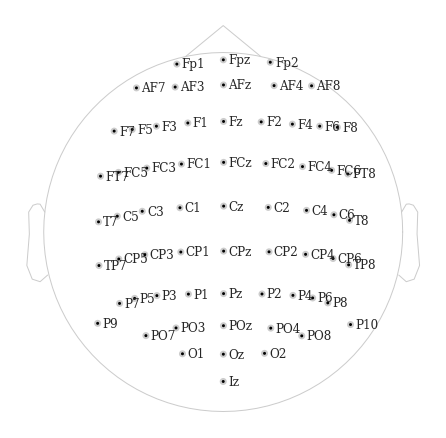

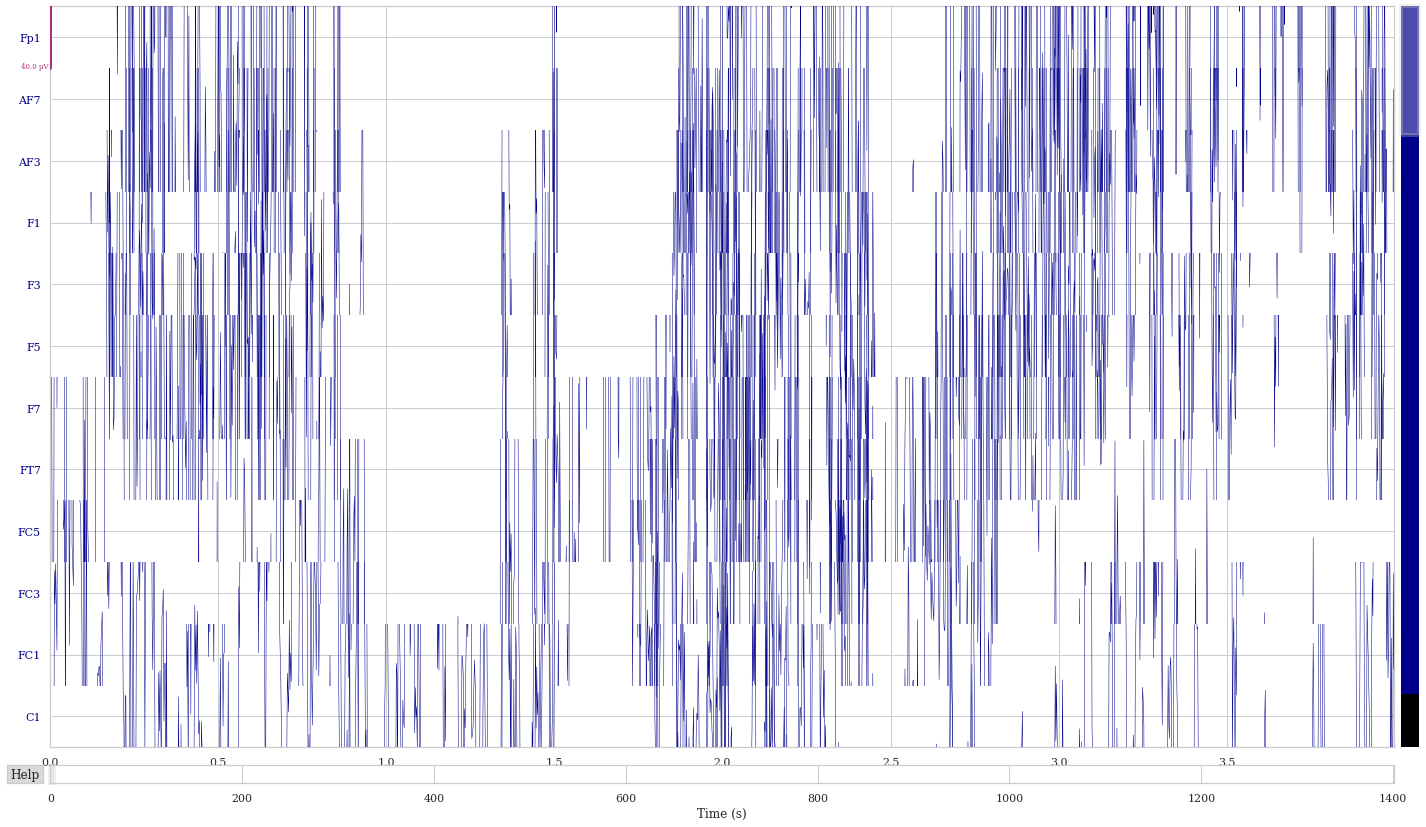

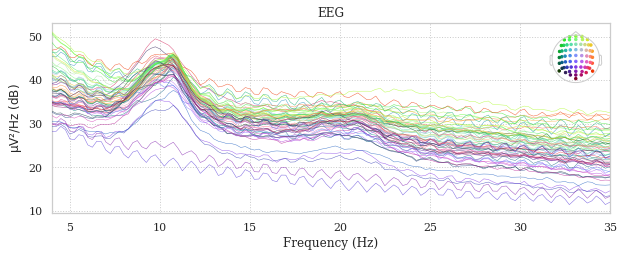

In [16]:
dataset = Cho2017()
print("There is {} subjects and {} sessions in this dataset".format(
    len(dataset.subject_list), dataset.n_sessions)
)

subj=[1,2]
# example I chose from clinical BCI in the chapter I wrote...
data = dataset.get_data(subjects=subj)
subject, session, run = 1, "session_0", "run_0"
raw = data[subject][session][run]
datasets = [BNCI2015004()]

# montage
_ = raw.plot_sensors(show_names=True)
# raw time series
_ = raw.plot(duration=4, n_channels=12, color={'eeg':'darkblue'})
# plot power spectra
_ = raw.plot_psd(fmin=4., fmax=35, picks=['eeg'])

### 2.2. Apply FC estimates & classification
We could also perform some stat...& connectomes... to see
classification & comparison with the state-of-the-art methods

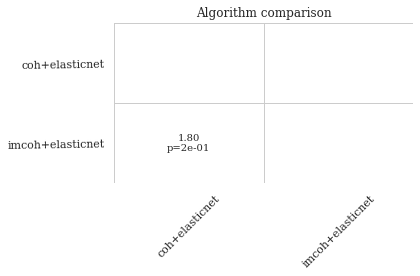

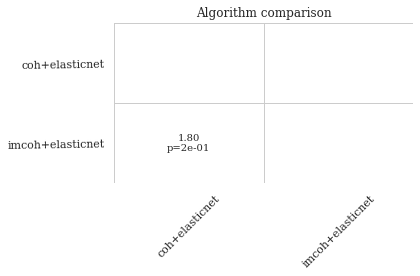

In [17]:
# here, we work with a subset of electrodes
set_log_level("error")
warnings.filterwarnings("ignore")

datasets = dataset
datasets.subject_list=subj

freqbands = {
    #     "delta": [2, 4],
    #     "theta": [4, 8],
    #     "alpha": [8, 12],
    #     "beta": [15, 30],
    #     "gamma": [30, 45],
    "defaultBand": [8, 35],
}


spectral_met = [
    "coh",
    "imcoh"
]


for f in freqbands:
        fmin = freqbands[f][0]
        fmax = freqbands[f][1]

        paradigm = LeftRightImagery(fmin=fmin, fmax=fmax, channels=["C3", "C4", "Cz"]) # to be changed if necessary
        
        pipelines = {}
        for sm in spectral_met:
            ft = FunctionalTransformer(
                delta=1, ratio=0.5, method=sm, fmin=fmin, fmax=fmax
            )
            pname_preDR = sm + "+elasticnet"
            pipelines[pname_preDR] = Pipeline(
                steps=[
                    ("sm", ft),
                    ("spd", EnsureSPD()),
                    ("tg", TangentSpace(metric="riemann")),
                    (
                        "LogistReg",
                        LogisticRegression(
                            penalty="elasticnet",
                            l1_ratio=0.15,
                            intercept_scaling=1000.0,
                            solver="saga",
                        ),
                    ),
                ]
            )

        evaluation = WithinSessionEvaluationFCDR(
            fmin=fmin,
            fmax=fmax,
            paradigm=paradigm,
            datasets=datasets,
            n_jobs=-1,
            random_state=42,
            return_epochs=True,
            overwrite=True,
        )
        results = evaluation.process(pipelines)

stats = compute_dataset_statistics(results)
P, T = find_significant_differences(stats)

summary_plot(P,T)

## References:
- papers connectivity?
- Paper ICASSP
- Paper TBME + link to the associated repo?